 1. Download and Extract the Dataset




In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz # Download the IMDB movie reviews dataset
!tar -xzf aclImdb_v1.tar.gz # Extract the contents of the compressed file


--2025-05-21 14:05:43--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.4’

aclImdb_v1.tar.gz.4 100%[===================>]  80.23M  14.4MB/s    in 9.6s    

2025-05-21 14:05:53 (8.32 MB/s) - ‘aclImdb_v1.tar.gz.4’ saved [84125825/84125825]



 2. Load and Preprocess the Data

In [ ]:
import os
from sklearn.utils import shuffle  # used to shuffle the data randomly

# Function to load text and labels from a given directory
def load_imdb_data(data_dir):
    texts, labels = [], []
    for label_type in ['pos', 'neg']:  # loop through positive and negative folders
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):  # loop through each file in the folder
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)  # label: 1 for pos, 0 for neg
    return texts, labels

# Load training and test data
train_texts, train_labels = load_imdb_data('aclImdb/train')
test_texts, test_labels = load_imdb_data('aclImdb/test')

# Shuffle the data to avoid any order bias
train_texts, train_labels = shuffle(train_texts, train_labels, random_state=42)
test_texts, test_labels = shuffle(test_texts, test_labels, random_state=42)


3. Text Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Parameters
max_words = 10000 # maximum number of words to keep based on frequency.
maxlen = 500 # ensures that all input sequences are of the same fixed length (500 tokens).

# Tokenize
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences of integers (word indices)
x_train = tokenizer.texts_to_sequences(train_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to ensure uniform input length for the model
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Convert labels to NumPy arrays for training
y_train = np.array(train_labels)
y_test = np.array(test_labels)


 4. Build the CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential([
    Embedding(max_words, 128, input_length=maxlen),# Converts word indices into dense vectors of size 128

    Conv1D(128, 5, activation='relu'), # Applies 128 filters of size 5 to extract local features

    MaxPooling1D(pool_size=2),  # Downsamples the output of the convolution to reduce dimensionality

    Dropout(0.5),#  Randomly drops 50% of the units to reduce overfitting

    GlobalMaxPooling1D(),  # Flattens the feature maps into a single vector

    Dense(10, activation='relu'),  # Fully connected layer with 10 units and ReLU activation

    Dense(1, activation='sigmoid')  # Single neuron with sigmoid activation for binary classification

])
model.build(input_shape=(None, maxlen))  # explicitly build the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])# Compile the model with binary cross-entropy loss and Adam optimizer

# Display the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 496, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 248, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 248, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,363,349 (5.20 MB)

 Trainable params: 1,363,349 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

 5. Train and Evaluate

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=64,
    # callbacks=[EarlyStopping(monitor='val_loss', patience=2)]  # EarlyStopping was TESTED and It was removed because overfitting started around epoch 3,
    # so training was manually limited to 2 epochs for better generalization.
)
# Evaluate on test set
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 463ms/step - accuracy: 0.9671 - loss: 0.1065 - val_accuracy: 0.8992 - val_loss: 0.2609
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 201s 459ms/step - accuracy: 0.9854 - loss: 0.0518 - val_accuracy: 0.8938 - val_loss: 0.2707
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.8820 - loss: 0.2825
Test Accuracy: 0.8816400170326233


6. Print Some Predictions with Actual Text


In [ ]:
y_pred_prob = model.predict(x_test)# Predict probabilities for test set

y_pred = (y_pred_prob > 0.5).astype("int32") # Convert probabilities to binary class predictions (threshold = 0.5)

index_word = {v: k for k, v in tokenizer.word_index.items()}# Create a reverse dictionary to map word indices back to words

def decode_review(seq): # Function to decode a sequence of word indices back to a readable review
    return ' '.join([index_word.get(i, '?') for i in seq if i != 0])

# Print a few sample reviews with their actual and predicted labels
for i in range(5):
    print(f"\n--- Review #{i+1} ---")
    print("Review Text:")
    print(decode_review(x_test[i]))
    print("Actual:", "Positive" if y_test[i] == 1 else "Negative")
    print("Predicted:", "Positive" if y_pred[i] == 1 else "Negative")
    print("="*80)

782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step

--- Review #1 ---
Review Text:
i can't comment on the accuracy of this production historical or literary but i can say that i enjoyed it if there is a god the sound track will be released work is truly enduring twenty years on i am still moved by the haunting themes of this production and return to it frequently br br the story the entry into society of catherine somewhat awkward and possessed of an interest in gothic stories early pulp fiction catherine on bath in the company of mrs allen where she meets henry she is invited to visit the at the seat of the and somewhat challenged general who has the unfortunate that there is wealth br br where mutual attraction mixes with family is inevitable this coupled with vivid imagination leads her to fear for her safety her eventual departure is marred by and counter of deception and br br but the attraction between catherine and henry stands these trials he returns to provide a happy ending this fina

7. Evaluation metrics

              precision    recall  f1-score   support

    Negative       0.87      0.90      0.88     12500
    Positive       0.90      0.86      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



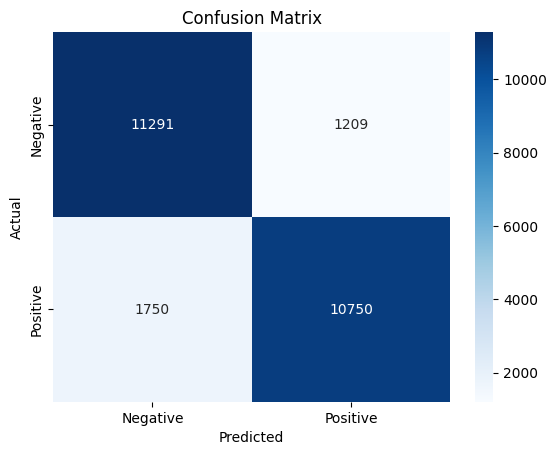

In [ ]:
# Import necessary libraries for evaluation and visualization
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print detailed classification metrics: precision, recall, f1-score for each class
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Compute the confusion matrix to see counts of true positives, true negatives, false positives, and false negatives
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap with annotations
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

# Label axes and add title to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


 Interpretation of Evaluation:

 The model achieved approximately 88% accuracy on the test set, indicating good overall performance in classifying positive and negative reviews.

Precision and recall scores are balanced for both classes (Positive and Negative), with slight variations:
- Negative class: Higher recall (0.90), the model correctly identifies most negative reviews.
- Positive class: Higher precision (0.90),  positive predictions are usually correct

F1-Scores (both 0.88) reflect a good balance between precision and recall for both classes.

The confusion matrix confirms most predictions are correct, with few misclassifications.

 Overall, the model performs well on unseen data. There is still room for improvement through further tuning, more data, or additional regularization.

